In [ ]:
# The core code was taken from https://github.com/blazejosinski/lm_nav repository and then modified to our need


In [1]:
from lm_nav.navigation_graph import NavigationGraph
from lm_nav.utils import rectify_and_crop
from pathlib import Path
import numpy as np
import io
from PIL import Image
import random
from tqdm import tqdm
import clip
from torchvision.transforms.functional import to_pil_image
import PIL
import copy
from lm_nav.optimal_route import nodes_landmarks_similarity
from collections import deque
from lm_nav.optimal_route import dijskra_transform
import heapq
import torch
from embedding_optimizer import EmbeddingOptimizer
from helper import preprocess_image
from torchvision import transforms
import toml
from tqdm import tqdm

/home/chashi/.local/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
original_graph = NavigationGraph("graphs/graph_rectified_cropped.pkl")

In [3]:
landmarks=['a glass building', 
            'a square with a large tree', 
            'a square with a tree', 
            'a white building', 
            'traffic lights', 
            'a white car', 
            'a disabled Parking spot', 
            'a trailer', 
            'a building with a red-black wall', 
            'a fire hydrant', 
            'a stop sign', 
            'an orange traffic cone', 
            'a manhole cover', 
            'a blue semi-truck', 
            'a red building', 
            'a picnic bench', 
            'a white truck', 
            'a white trailer', 
            'a traffic cone', 
            'a grove', 
            'a blue dumpster']

In [4]:
similarity_matrix = nodes_landmarks_similarity(original_graph, landmarks)

In [6]:
np.argmax(similarity_matrix, axis=0)

array([244, 181, 181, 170, 204, 217, 184,  45, 170, 138,  77, 257, 138,
       254, 170,  61, 217, 230, 257,  37,  76])

In [41]:
top_5_indexes_per_column = []

for column in range(similarity_matrix.shape[1]):  # matrix.shape[1] gives the number of columns (21 in this case)
    column_values = similarity_matrix[:, column]  # Get all values in the current column
    top_5_indexes = np.argsort(column_values)[-10:][::-1]  # Argsort, then get last 5 for top values, reverse for descending
    top_5_indexes_per_column.append(top_5_indexes)

# top_5_indexes_per_column now contains the row indexes of the top 5 values for each column
for i, indexes in enumerate(top_5_indexes_per_column):
    print(f"Column {landmarks[i]}: Row indexes of top 5 values = {indexes}")

Column a glass building: Row indexes of top 5 values = [244 171 170  61 220 172 168 173  81 167]
Column a square with a large tree: Row indexes of top 5 values = [181 261 180 268 270 236  60 238 186  61]
Column a square with a tree: Row indexes of top 5 values = [181 180 238 261  60 268 270 234  61 236]
Column a white building: Row indexes of top 5 values = [170 263 102 244 172 265 219 168 182   0]
Column traffic lights: Row indexes of top 5 values = [204 257 250 111 160 112 251  74 215  35]
Column a white car: Row indexes of top 5 values = [217 202 203 241 230  18  12 259  74 223]
Column a disabled Parking spot: Row indexes of top 5 values = [184 163 183 186 160 221  12 233  20  13]
Column a trailer: Row indexes of top 5 values = [ 45 230  20  52  10  22  13  43  21  18]
Column a building with a red-black wall: Row indexes of top 5 values = [170 168 167 158 166 165 160 163 172 177]
Column a fire hydrant: Row indexes of top 5 values = [138  77 181 160 257  10  95 264 217 148]
Column a 

In [42]:
img_unique_set = set()
for i, indexes in enumerate(top_5_indexes_per_column):
    img_unique_set = img_unique_set.union(set(indexes))

In [26]:
txt_unique_set = set()
for i, indexes in enumerate(top_5_indexes_per_column):
    txt_unique_set = txt_unique_set.union(set(indexes))

In [18]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max for numerical stability
    return e_x / e_x.sum(axis=1, keepdims=True)



In [ ]:
# Apply softmax to each row (axis=1) of the matrix
probabilities = softmax(similarity_matrix)

# Decide a class for each row by choosing the column with the highest probability
classes = np.argmax(probabilities, axis=1)

In [24]:
original_img_dict = {i:classes[i] for i in list(img_unique_set)}

In [28]:
original_txt_dict = {i:classes[i] for i in list(txt_unique_set)}

In [32]:
len(original_txt_dict)

40

In [36]:
# Calculate the accuracy of matching key-value pairs
def calculate_accuracy(dict1, dict2):
    # Ensure that both dictionaries have the same keys for a fair comparison
    if dict1.keys() != dict2.keys():
        return "Dictionaries have different sets of keys."
    
    total_keys = len(dict1)
    matching_pairs_count = sum(1 for key in dict1 if key in dict2 and dict1[key] == dict2[key])
    
    accuracy = (matching_pairs_count / total_keys) * 100
    return accuracy

# Original Detection

In [63]:
import torch
import torchvision.transforms as transforms
import numpy as np
import PIL.Image
import io

def nodes_landmarks_similarity_with_noise(
    graph: NavigationGraph, landmarks, noise_std
) -> np.ndarray:
    result = np.zeros((graph.vert_count, len(landmarks)))
    model, preprocess = clip.load("ViT-L/14")
    model.cuda().eval()

    text_labels = ["A photo of " + desc for desc in landmarks]
    text_tokens = clip.tokenize(text_labels).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    transform_to_tensor = transforms.ToTensor()
    for i in range(graph.vert_count):
        rectified_croped_images = [PIL.Image.fromarray(np.array(PIL.Image.open(io.BytesIO(img)))) for img in graph._images[i]]
        images_as_tensors = [transform_to_tensor(image) for image in rectified_croped_images]

        input_tensor = images_as_tensors[0]  
        noisy_images_tensors = []
        for tensor_image in images_as_tensors:
            noise = torch.randn_like(tensor_image) * noise_std
            noisy_image = tensor_image + noise
            noisy_images_tensors.append(noisy_image)
        
        transform_to_pil = transforms.ToPILImage()
        noisy_images_pil = [transform_to_pil(tensor) for tensor in noisy_images_tensors]

        processed_images = [preprocess(image) for image in noisy_images_pil]
        image_input = torch.tensor(np.stack(processed_images)).cuda()
        with torch.no_grad():
            image_features = model.encode_image(image_input).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
        result[i, :] = np.max(similarity, axis=1)
    return result

# Compute Feature Map Difference

In [96]:
import torch
import torchvision.transforms as transforms
import numpy as np
import PIL.Image
import io
import clip

def compute_feature_map_differences(graph, landmarks, noise_std):
    model, preprocess = clip.load("ViT-L/14")
    model.cuda().eval()

    text_labels = ["A photo of " + desc for desc in landmarks]
    text_tokens = clip.tokenize(text_labels).cuda()

    with torch.no_grad():
        model.encode_text(text_tokens).float()  

    transform_to_tensor = transforms.ToTensor()
    transform_to_pil = transforms.ToPILImage()

    differences = np.zeros((graph.vert_count, 1))  

    for i in range(graph.vert_count):
        original_images_pil = [PIL.Image.fromarray(np.array(PIL.Image.open(io.BytesIO(img)))) for img in graph._images[i]]
        original_images_tensors = [transform_to_tensor(image) for image in original_images_pil]

        noisy_images_tensors = []
        for tensor_image in original_images_tensors:
            noise = torch.randn_like(tensor_image) * noise_std
            noisy_image = tensor_image + noise
            noisy_images_tensors.append(noisy_image)


        processed_original_images = [preprocess(image) for image in original_images_pil]
        original_image_input = torch.stack(processed_original_images).cuda()


        noisy_images_pil = [transform_to_pil(tensor) for tensor in noisy_images_tensors]
        processed_noisy_images = [preprocess(image) for image in noisy_images_pil]
        noisy_image_input = torch.stack(processed_noisy_images).cuda()

        with torch.no_grad():
            original_image_features = model.encode_image(original_image_input).float()
            noisy_image_features = model.encode_image(noisy_image_input).float()


        original_image_features /= original_image_features.norm(dim=-1, keepdim=True)
        noisy_image_features /= noisy_image_features.norm(dim=-1, keepdim=True)
        diff = (noisy_image_features - original_image_features).norm(dim=1).cpu().numpy()
        

        differences[i] = diff.mean()

    return differences



In [78]:
noises = [0.00, 0.0000001, 0.0000003, 0.0000005, 0.0000007, 0.0000009, 0.000001, 0.000003, 0.000005, 0.000007, 0.000009, 0.000001, 0.00003, 0.00005, 0.00007, 0.00009, 0.0001, 0.0003, 0.0005, 0.0007, 0.0009, 0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9]

In [46]:
from tqdm import tqdm

In [97]:
for noise in tqdm(noises):
    
    # Now, perform feature map difference analysis
    # Note: compute_feature_map_differences needs to be adapted if it's to directly use the features returned from the modified function
    differences = compute_feature_map_differences(original_graph, landmarks, noise)
    
    # Print or analyze the differences
    print(f"Average feature map difference for noise level {noise}: {differences.mean()}")

  3%|▎         | 1/36 [00:15<09:04, 15.56s/it]

Average feature map difference for noise level 0.0: 0.0


  6%|▌         | 2/36 [00:30<08:46, 15.48s/it]

Average feature map difference for noise level 1e-07: 0.1300707022599179


  8%|▊         | 3/36 [00:46<08:28, 15.41s/it]

Average feature map difference for noise level 3e-07: 0.13297491040911605


 11%|█         | 4/36 [01:01<08:15, 15.50s/it]

Average feature map difference for noise level 5e-07: 0.13517238175590263


 14%|█▍        | 5/36 [01:17<08:00, 15.51s/it]

Average feature map difference for noise level 7e-07: 0.13388634073755723


 17%|█▋        | 6/36 [01:34<07:57, 15.92s/it]

Average feature map difference for noise level 9e-07: 0.13479818360839815


 19%|█▉        | 7/36 [01:51<07:57, 16.48s/it]

Average feature map difference for noise level 1e-06: 0.1347419683881801


 22%|██▏       | 8/36 [02:08<07:47, 16.69s/it]

Average feature map difference for noise level 3e-06: 0.13473308201638057


 25%|██▌       | 9/36 [02:26<07:38, 16.97s/it]

Average feature map difference for noise level 5e-06: 0.13470149412751198


 28%|██▊       | 10/36 [02:44<07:25, 17.14s/it]

Average feature map difference for noise level 7e-06: 0.13499199912595233


 31%|███       | 11/36 [03:00<07:06, 17.06s/it]

Average feature map difference for noise level 9e-06: 0.1355171088370488


 33%|███▎      | 12/36 [03:18<06:54, 17.26s/it]

Average feature map difference for noise level 1e-06: 0.13429849053458345


 36%|███▌      | 13/36 [03:34<06:23, 16.68s/it]

Average feature map difference for noise level 3e-05: 0.13596805300322368


 39%|███▉      | 14/36 [03:49<05:57, 16.23s/it]

Average feature map difference for noise level 5e-05: 0.1352778932870292


 42%|████▏     | 15/36 [04:04<05:34, 15.95s/it]

Average feature map difference for noise level 7e-05: 0.13526698475261387


 44%|████▍     | 16/36 [04:19<05:14, 15.73s/it]

Average feature map difference for noise level 9e-05: 0.13482603693394352


 47%|████▋     | 17/36 [04:35<05:00, 15.81s/it]

Average feature map difference for noise level 0.0001: 0.13450179600136744


 50%|█████     | 18/36 [04:53<04:55, 16.41s/it]

Average feature map difference for noise level 0.0003: 0.13491333337674896


 53%|█████▎    | 19/36 [05:11<04:47, 16.92s/it]

Average feature map difference for noise level 0.0005: 0.13458836196566656


 56%|█████▌    | 20/36 [05:29<04:33, 17.08s/it]

Average feature map difference for noise level 0.0007: 0.13373715567181435


 58%|█████▊    | 21/36 [05:47<04:20, 17.35s/it]

Average feature map difference for noise level 0.0009: 0.13639556281536602


 61%|██████    | 22/36 [06:04<04:01, 17.22s/it]

Average feature map difference for noise level 0.001: 0.14188667552934275


 64%|██████▍   | 23/36 [06:22<03:47, 17.51s/it]

Average feature map difference for noise level 0.003: 0.4374603126332057


 67%|██████▋   | 24/36 [06:39<03:29, 17.47s/it]

Average feature map difference for noise level 0.005: 0.48803406771567226


 69%|██████▉   | 25/36 [06:55<03:05, 16.90s/it]

Average feature map difference for noise level 0.007: 0.5256686908521241


 72%|███████▏  | 26/36 [07:10<02:44, 16.47s/it]

Average feature map difference for noise level 0.009: 0.5542668152412922


 75%|███████▌  | 27/36 [07:25<02:25, 16.15s/it]

Average feature map difference for noise level 0.01: 0.5661993220770102


 78%|███████▊  | 28/36 [07:41<02:07, 15.96s/it]

Average feature map difference for noise level 0.03: 0.6524441085702224


 81%|████████  | 29/36 [07:57<01:50, 15.84s/it]

Average feature map difference for noise level 0.05: 0.679871310647443


 83%|████████▎ | 30/36 [08:12<01:33, 15.66s/it]

Average feature map difference for noise level 0.07: 0.7149102904384942


 86%|████████▌ | 31/36 [08:28<01:18, 15.70s/it]

Average feature map difference for noise level 0.09: 0.7500601708889008


 89%|████████▉ | 32/36 [08:46<01:05, 16.40s/it]

Average feature map difference for noise level 0.1: 0.7661007089580564


 92%|█████████▏| 33/36 [09:03<00:49, 16.65s/it]

Average feature map difference for noise level 0.3: 1.0292751546815144


 94%|█████████▍| 34/36 [09:21<00:34, 17.06s/it]

Average feature map difference for noise level 0.5: 1.0576658377544486


 97%|█████████▋| 35/36 [09:38<00:17, 17.14s/it]

Average feature map difference for noise level 0.7: 1.0580530805553463


100%|██████████| 36/36 [09:56<00:00, 16.58s/it]

Average feature map difference for noise level 0.9: 1.0576984097631714


In [82]:
for noise in tqdm(noises):
    noisy_similarities = nodes_landmarks_similarity_with_noise(original_graph, landmarks, noise)
    # Apply softmax to each row (axis=1) of the matrix
    probabilities = softmax(noisy_similarities)

    # Decide a class for each row by choosing the column with the highest probability
    classes = np.argmax(probabilities, axis=1)
    original_noisy_img_dict = {i:classes[i] for i in list(img_unique_set)}
    accuracy = calculate_accuracy(original_img_dict, original_noisy_img_dict)
    print(f"Noise: {noise} - Original Accuracy : {accuracy}%")
    
    

  3%|▎         | 1/36 [00:14<08:44, 14.97s/it]

Noise: 0.0 - Original Accuracy : 100.0%


  6%|▌         | 2/36 [00:29<08:26, 14.89s/it]

Noise: 1e-07 - Original Accuracy : 87.62886597938144%


  8%|▊         | 3/36 [00:44<08:13, 14.95s/it]

Noise: 3e-07 - Original Accuracy : 87.62886597938144%


 11%|█         | 4/36 [00:59<07:58, 14.95s/it]

Noise: 5e-07 - Original Accuracy : 88.65979381443299%


 14%|█▍        | 5/36 [01:14<07:43, 14.95s/it]

Noise: 7e-07 - Original Accuracy : 84.5360824742268%


 17%|█▋        | 6/36 [01:29<07:28, 14.95s/it]

Noise: 9e-07 - Original Accuracy : 86.5979381443299%


 19%|█▉        | 7/36 [01:44<07:15, 15.01s/it]

Noise: 1e-06 - Original Accuracy : 87.62886597938144%


 22%|██▏       | 8/36 [01:59<06:59, 15.00s/it]

Noise: 3e-06 - Original Accuracy : 85.56701030927834%


 25%|██▌       | 9/36 [02:14<06:45, 15.01s/it]

Noise: 5e-06 - Original Accuracy : 85.56701030927834%


 28%|██▊       | 10/36 [02:29<06:29, 15.00s/it]

Noise: 7e-06 - Original Accuracy : 85.56701030927834%


 31%|███       | 11/36 [02:46<06:30, 15.61s/it]

Noise: 9e-06 - Original Accuracy : 89.69072164948454%


 33%|███▎      | 12/36 [03:04<06:26, 16.10s/it]

Noise: 1e-06 - Original Accuracy : 86.5979381443299%


 36%|███▌      | 13/36 [03:18<06:02, 15.76s/it]

Noise: 3e-05 - Original Accuracy : 85.56701030927834%


 39%|███▉      | 14/36 [03:33<05:41, 15.51s/it]

Noise: 5e-05 - Original Accuracy : 86.5979381443299%


 42%|████▏     | 15/36 [03:48<05:22, 15.34s/it]

Noise: 7e-05 - Original Accuracy : 85.56701030927834%


 44%|████▍     | 16/36 [04:03<05:03, 15.17s/it]

Noise: 9e-05 - Original Accuracy : 87.62886597938144%


 47%|████▋     | 17/36 [04:18<04:46, 15.07s/it]

Noise: 0.0001 - Original Accuracy : 89.69072164948454%


 50%|█████     | 18/36 [04:33<04:29, 15.00s/it]

Noise: 0.0003 - Original Accuracy : 84.5360824742268%


 53%|█████▎    | 19/36 [04:48<04:13, 14.93s/it]

Noise: 0.0005 - Original Accuracy : 86.5979381443299%


 56%|█████▌    | 20/36 [05:03<03:59, 14.96s/it]

Noise: 0.0007 - Original Accuracy : 88.65979381443299%


 58%|█████▊    | 21/36 [05:17<03:43, 14.90s/it]

Noise: 0.0009 - Original Accuracy : 84.5360824742268%


 61%|██████    | 22/36 [05:32<03:27, 14.82s/it]

Noise: 0.001 - Original Accuracy : 86.5979381443299%


 64%|██████▍   | 23/36 [05:47<03:12, 14.79s/it]

Noise: 0.003 - Original Accuracy : 56.70103092783505%


 67%|██████▋   | 24/36 [06:02<02:57, 14.79s/it]

Noise: 0.005 - Original Accuracy : 57.73195876288659%


 69%|██████▉   | 25/36 [06:16<02:42, 14.81s/it]

Noise: 0.007 - Original Accuracy : 51.546391752577314%


 72%|███████▏  | 26/36 [06:31<02:28, 14.81s/it]

Noise: 0.009 - Original Accuracy : 49.48453608247423%


 75%|███████▌  | 27/36 [06:46<02:13, 14.80s/it]

Noise: 0.01 - Original Accuracy : 48.45360824742268%


 78%|███████▊  | 28/36 [07:01<01:58, 14.85s/it]

Noise: 0.03 - Original Accuracy : 38.144329896907216%


 81%|████████  | 29/36 [07:16<01:44, 14.87s/it]

Noise: 0.05 - Original Accuracy : 28.865979381443296%


 83%|████████▎ | 30/36 [07:31<01:28, 14.81s/it]

Noise: 0.07 - Original Accuracy : 24.742268041237114%


 86%|████████▌ | 31/36 [07:45<01:13, 14.76s/it]

Noise: 0.09 - Original Accuracy : 26.804123711340207%


 89%|████████▉ | 32/36 [08:00<00:58, 14.74s/it]

Noise: 0.1 - Original Accuracy : 20.618556701030926%


 92%|█████████▏| 33/36 [08:15<00:44, 14.74s/it]

Noise: 0.3 - Original Accuracy : 4.123711340206185%


 94%|█████████▍| 34/36 [08:30<00:29, 14.85s/it]

Noise: 0.5 - Original Accuracy : 7.216494845360824%


 97%|█████████▋| 35/36 [08:45<00:14, 14.83s/it]

Noise: 0.7 - Original Accuracy : 3.0927835051546393%


100%|██████████| 36/36 [08:59<00:00, 14.99s/it]

Noise: 0.9 - Original Accuracy : 3.0927835051546393%


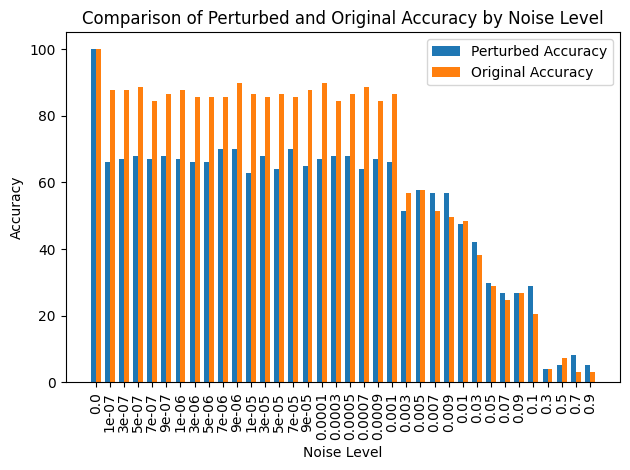

In [83]:
import matplotlib.pyplot as plt
import numpy as np

noise_levels = np.array([0.0, 1e-07, 3e-07, 5e-07, 7e-07, 9e-07, 1e-06, 3e-06, 5e-06, 7e-06,
                         9e-06, 1e-05, 3e-05, 5e-05, 7e-05, 9e-05, 0.0001, 0.0003, 0.0005,
                         0.0007, 0.0009, 0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.03,
                         0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9])

perturbed_accuracy = np.array([
    100.0, 65.97938144329896, 67.0103092783505, 68.04123711340206, 67.0103092783505, 68.04123711340206,
    67.0103092783505, 65.97938144329896, 65.97938144329896, 70.10309278350515, 70.10309278350515, 62.88659793814433,
    68.04123711340206, 63.91752577319587, 70.10309278350515, 64.94845360824742, 67.0103092783505, 68.04123711340206,
    68.04123711340206, 63.91752577319587, 67.0103092783505, 65.97938144329896, 51.546391752577314, 57.73195876288659,
    56.70103092783505, 56.70103092783505, 47.42268041237113, 42.2680412371134, 29.896907216494846, 26.804123711340207,
    26.804123711340207, 28.865979381443296, 4.123711340206185, 5.154639175257731, 8.24742268041237, 5.154639175257731
])

original_accuracy = np.array([100, 87.62, 87.62, 88.65, 84.53, 86.59, 87.62, 85.56, 85.56, 85.56,
                               89.69, 86.59, 85.56, 86.59, 85.56, 87.62, 89.69, 84.53, 86.59, 88.65,
                               84.53, 86.59, 56.70, 57.73, 51.54, 49.48, 48.45, 38.14, 28.86, 24.74,
                               26.80, 20.61, 4.12, 7.21, 3.09, 3.09])

fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(noise_levels))

bar1 = ax.bar(index, perturbed_accuracy, bar_width, label='Perturbed Accuracy')
bar2 = ax.bar(index + bar_width, original_accuracy, bar_width, label='Original Accuracy')

ax.set_xlabel('Noise Level')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Perturbed and Original Accuracy by Noise Level')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(noise_levels, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()


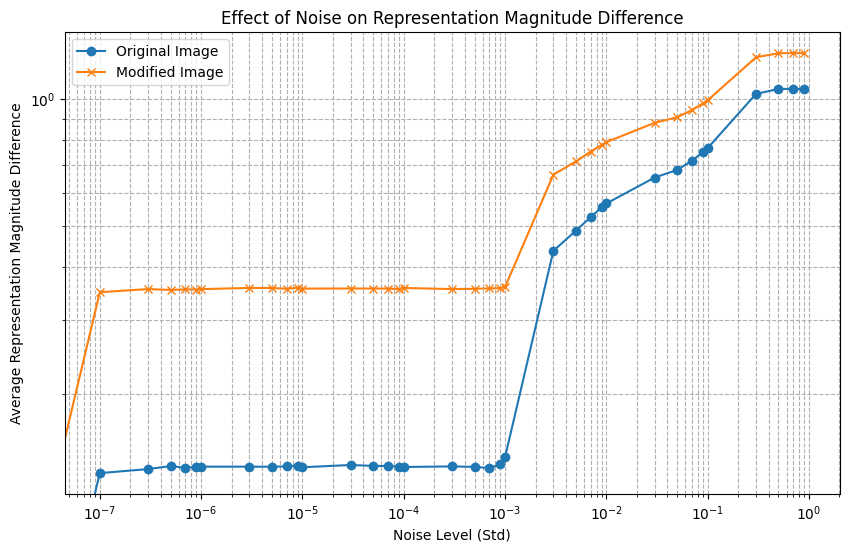

In [106]:
import matplotlib.pyplot as plt

# Noise levels used in the experiment
noise_levels = [
    0.0, 1e-07, 3e-07, 5e-07, 7e-07, 9e-07, 1e-06, 3e-06, 5e-06, 7e-06,
    9e-06, 1e-05, 3e-05, 5e-05, 7e-05, 9e-05, 0.0001, 0.0003, 0.0005, 0.0007,
    0.0009, 0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.03, 0.05, 0.07,
    0.09, 0.1, 0.3, 0.5, 0.7, 0.9
]

# Average feature map differences for the original image
avg_diff_original = [
    0.0, 0.1300707022599179, 0.13297491040911605, 0.13517238175590263, 0.13388634073755723, 0.13479818360839815,
    0.1347419683881801, 0.13473308201638057, 0.13470149412751198, 0.13499199912595233, 0.1355171088370488,
    0.13429849053458345, 0.13596805300322368, 0.1352778932870292, 0.13526698475261387, 0.13482603693394352,
    0.13450179600136744, 0.13491333337674896, 0.13458836196566656, 0.13373715567181435, 0.13639556281536602,
    0.14188667552934275, 0.4374603126332057, 0.48803406771567226, 0.5256686908521241, 0.5542668152412922,
    0.5661993220770102, 0.6524441085702224, 0.679871310647443, 0.7149102904384942, 0.7500601708889008,
    0.7661007089580564, 1.0292751546815144, 1.0576658377544486, 1.0580530805553463, 1.0576984097631714
]

# Average feature map differences for the modified image
avg_diff_modified = [
    0.0, 0.3488991590176555, 0.35502166627979964, 0.35334000543510313, 0.354438029765654, 0.3541166734137981,
    0.3548477025126382, 0.3572523791691382, 0.35703168643249883, 0.35560081266670773, 0.35746394156766453,
    0.35588567639640767, 0.35608328176702525, 0.3560140114143598, 0.3559149363272482, 0.35499210896895084,
    0.3571679298933461, 0.3549640432214565, 0.35549340257756146, 0.3562963602703296, 0.3568812931778034,
    0.35892785198927664, 0.6627980733317818, 0.7120645712370132, 0.7512202849062252, 0.7794829086330099,
    0.7915628967319172, 0.8790632292185165, 0.9065753058417431, 0.9424781932388583, 0.9778479382087684,
    0.9940756856172677, 1.2569968494026835, 1.2853783720931463, 1.2859650821976366, 1.2856110703499216
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, avg_diff_original, label='Original Image', marker='o')
plt.plot(noise_levels, avg_diff_modified, label='Modified Image', marker='x')
plt.xlabel('Noise Level (Std)')
plt.ylabel('Average Representation Magnitude Difference')
plt.title('Effect of Noise on Representation Magnitude Difference')
plt.xscale('log')  # Since the noise levels span a wide range, a logarithmic scale might be more appropriate
plt.yscale('log')  # Assuming the differences can also span several orders of magnitude
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


  6%|▋         | 1/16 [00:12<03:08, 12.54s/it]
Noise: 0.0 - Original Accuracy : 100.0%
 12%|█▎        | 2/16 [00:25<02:56, 12.58s/it]
Noise: 0.001 - Original Accuracy : 88.65979381443299%
 19%|█▉        | 3/16 [00:37<02:43, 12.60s/it]
Noise: 0.003 - Original Accuracy : 51.546391752577314%
 25%|██▌       | 4/16 [00:50<02:31, 12.60s/it]
Noise: 0.005 - Original Accuracy : 53.608247422680414%
 31%|███▏      | 5/16 [01:02<02:18, 12.56s/it]
Noise: 0.007 - Original Accuracy : 51.546391752577314%
 38%|███▊      | 6/16 [01:15<02:05, 12.58s/it]
Noise: 0.009 - Original Accuracy : 51.546391752577314%
 44%|████▍     | 7/16 [01:28<01:53, 12.61s/it]
Noise: 0.01 - Original Accuracy : 47.42268041237113%
 50%|█████     | 8/16 [01:40<01:40, 12.61s/it]
Noise: 0.03 - Original Accuracy : 39.175257731958766%
 56%|█████▋    | 9/16 [01:53<01:28, 12.59s/it]
Noise: 0.05 - Original Accuracy : 29.896907216494846%
 62%|██████▎   | 10/16 [02:05<01:15, 12.56s/it]
Noise: 0.07 - Original Accuracy : 27.835051546391753%
 69%|██████▉   | 11/16 [02:18<01:02, 12.57s/it]
Noise: 0.09 - Original Accuracy : 22.68041237113402%
 75%|███████▌  | 12/16 [02:30<00:50, 12.58s/it]
Noise: 0.1 - Original Accuracy : 21.649484536082475%
 81%|████████▏ | 13/16 [02:43<00:37, 12.62s/it]
Noise: 0.3 - Original Accuracy : 3.0927835051546393%
 88%|████████▊ | 14/16 [02:56<00:25, 12.59s/it]
Noise: 0.5 - Original Accuracy : 2.0618556701030926%
 94%|█████████▍| 15/16 [03:08<00:12, 12.59s/it]
Noise: 0.7 - Original Accuracy : 7.216494845360824%
100%|██████████| 16/16 [03:21<00:00, 12.59s/it]
Noise: 0.9 - Original Accuracy : 3.0927835051546393%
  8%|▊         | 1/13 [00:12<02:31, 12.61s/it]
Noise: 0.5 - Original Accuracy : 3.0927835051546393%
 15%|█▌        | 2/13 [00:25<02:18, 12.58s/it]
Noise: 0.55 - Original Accuracy : 4.123711340206185%
 23%|██▎       | 3/13 [00:37<02:05, 12.58s/it]
Noise: 0.6 - Original Accuracy : 1.0309278350515463%
 31%|███       | 4/13 [00:50<01:53, 12.57s/it]
Noise: 0.65 - Original Accuracy : 3.0927835051546393%
 38%|███▊      | 5/13 [01:02<01:40, 12.60s/it]
Noise: 0.7 - Original Accuracy : 2.0618556701030926%
 46%|████▌     | 6/13 [01:15<01:28, 12.60s/it]
Noise: 0.75 - Original Accuracy : 3.0927835051546393%
 54%|█████▍    | 7/13 [01:28<01:15, 12.60s/it]
Noise: 0.8 - Original Accuracy : 6.185567010309279%
 62%|██████▏   | 8/13 [01:40<01:02, 12.58s/it]
Noise: 0.85 - Original Accuracy : 4.123711340206185%
 69%|██████▉   | 9/13 [01:53<00:50, 12.62s/it]
Noise: 0.9 - Original Accuracy : 3.0927835051546393%
 77%|███████▋  | 10/13 [02:05<00:37, 12.60s/it]
Noise: 0.95 - Original Accuracy : 2.0618556701030926%
 85%|████████▍ | 11/13 [02:18<00:25, 12.61s/it]
Noise: 1 - Original Accuracy : 8.24742268041237%
 92%|█████████▏| 12/13 [02:31<00:12, 12.61s/it]
Noise: 1.3 - Original Accuracy : 5.154639175257731%
100%|██████████| 13/13 [02:43<00:00, 12.60s/it]
Noise: 1.5 - Original Accuracy : 4.123711340206185%


# Modified Graph

In [100]:
modified_graph = NavigationGraph("graphs/random_fgsm_graph.pkl")

In [101]:
modified_dict = {}
for noise in tqdm(noises):
    
    # Now, perform feature map difference analysis
    # Note: compute_feature_map_differences needs to be adapted if it's to directly use the features returned from the modified function
    differences = compute_feature_map_differences(modified_graph, landmarks, noise)
    modified_dict[noise] = differences
    # Print or analyze the differences
    print(f"Average feature map difference for noise level {noise}: {differences.mean()}")

  3%|▎         | 1/36 [00:15<08:55, 15.31s/it]

Average feature map difference for noise level 0.0: 0.0


  6%|▌         | 2/36 [00:30<08:31, 15.05s/it]

Average feature map difference for noise level 1e-07: 0.3488991590176555


  8%|▊         | 3/36 [00:45<08:15, 15.02s/it]

Average feature map difference for noise level 3e-07: 0.35502166627979964


 11%|█         | 4/36 [00:59<07:56, 14.89s/it]

Average feature map difference for noise level 5e-07: 0.35334000543510313


 14%|█▍        | 5/36 [01:14<07:39, 14.82s/it]

Average feature map difference for noise level 7e-07: 0.354438029765654


 17%|█▋        | 6/36 [01:29<07:24, 14.83s/it]

Average feature map difference for noise level 9e-07: 0.3541166734137981


 19%|█▉        | 7/36 [01:44<07:09, 14.82s/it]

Average feature map difference for noise level 1e-06: 0.3548477025126382


 22%|██▏       | 8/36 [01:58<06:54, 14.81s/it]

Average feature map difference for noise level 3e-06: 0.3572523791691382


 25%|██▌       | 9/36 [02:14<06:42, 14.91s/it]

Average feature map difference for noise level 5e-06: 0.35703168643249883


 28%|██▊       | 10/36 [02:28<06:26, 14.88s/it]

Average feature map difference for noise level 7e-06: 0.35560081266670773


 31%|███       | 11/36 [02:43<06:12, 14.88s/it]

Average feature map difference for noise level 9e-06: 0.35746394156766453


 33%|███▎      | 12/36 [02:58<05:56, 14.86s/it]

Average feature map difference for noise level 1e-06: 0.35588567639640767


 36%|███▌      | 13/36 [03:13<05:43, 14.92s/it]

Average feature map difference for noise level 3e-05: 0.35608328176702525


 39%|███▉      | 14/36 [03:28<05:30, 15.02s/it]

Average feature map difference for noise level 5e-05: 0.3560140114143598


 42%|████▏     | 15/36 [03:44<05:18, 15.17s/it]

Average feature map difference for noise level 7e-05: 0.3559149363272482


 44%|████▍     | 16/36 [04:01<05:15, 15.79s/it]

Average feature map difference for noise level 9e-05: 0.35499210896895084


 47%|████▋     | 17/36 [04:19<05:09, 16.30s/it]

Average feature map difference for noise level 0.0001: 0.3571679298933461


 50%|█████     | 18/36 [04:35<04:52, 16.28s/it]

Average feature map difference for noise level 0.0003: 0.3549640432214565


 53%|█████▎    | 19/36 [04:52<04:41, 16.58s/it]

Average feature map difference for noise level 0.0005: 0.35549340257756146


 56%|█████▌    | 20/36 [05:09<04:28, 16.76s/it]

Average feature map difference for noise level 0.0007: 0.3570001024029238


 58%|█████▊    | 21/36 [05:25<04:08, 16.55s/it]

Average feature map difference for noise level 0.0009: 0.35313632542924056


 61%|██████    | 22/36 [05:43<03:55, 16.81s/it]

Average feature map difference for noise level 0.001: 0.35203969853816275


 64%|██████▍   | 23/36 [05:58<03:32, 16.35s/it]

Average feature map difference for noise level 0.003: 0.38886611399461896


 67%|██████▋   | 24/36 [06:13<03:10, 15.89s/it]

Average feature map difference for noise level 0.005: 0.4487518280101337


 69%|██████▉   | 25/36 [06:28<02:51, 15.55s/it]

Average feature map difference for noise level 0.007: 0.46447337263350863


 72%|███████▏  | 26/36 [06:42<02:33, 15.33s/it]

Average feature map difference for noise level 0.009: 0.47374573585798413


 75%|███████▌  | 27/36 [06:57<02:16, 15.17s/it]

Average feature map difference for noise level 0.01: 0.48001571439153


 78%|███████▊  | 28/36 [07:12<02:01, 15.13s/it]

Average feature map difference for noise level 0.03: 0.5603602638990759


 81%|████████  | 29/36 [07:27<01:45, 15.07s/it]

Average feature map difference for noise level 0.05: 0.5887999496013998


 83%|████████▎ | 30/36 [07:42<01:30, 15.00s/it]

Average feature map difference for noise level 0.07: 0.6258959604038609


 86%|████████▌ | 31/36 [07:57<01:14, 14.97s/it]

Average feature map difference for noise level 0.09: 0.669194943506083


 89%|████████▉ | 32/36 [08:12<00:59, 14.98s/it]

Average feature map difference for noise level 0.1: 0.6906249323766008


 92%|█████████▏| 33/36 [08:27<00:44, 14.92s/it]

Average feature map difference for noise level 0.3: 0.9873571252222542


 94%|█████████▍| 34/36 [08:42<00:29, 14.87s/it]

Average feature map difference for noise level 0.5: 1.0219540838286174


 97%|█████████▋| 35/36 [08:56<00:14, 14.84s/it]

Average feature map difference for noise level 0.7: 1.022681279791345


100%|██████████| 36/36 [09:11<00:00, 15.33s/it]

Average feature map difference for noise level 0.9: 1.0216377085919002


In [73]:
mod_similarity_matrix = nodes_landmarks_similarity(modified_graph, landmarks)

In [74]:
# Apply softmax to each row (axis=1) of the matrix
mod_probabilities = softmax(mod_similarity_matrix)

# Decide a class for each row by choosing the column with the highest probability
mod_classes = np.argmax(mod_probabilities, axis=1)

In [75]:
mod_img_dict = {i:mod_classes[i] for i in list(img_unique_set)}

In [76]:
noises = [0.00, 0.0000001, 0.0000003, 0.0000005, 0.0000007, 0.0000009, 0.000001, 0.000003, 0.000005, 0.000007, 0.000009, 0.000001, 0.00003, 0.00005, 0.00007, 0.00009, 0.0001, 0.0003, 0.0005, 0.0007, 0.0009, 0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9]

In [77]:
for noise in tqdm(noises):
    noisy_mod_similarities = nodes_landmarks_similarity_with_noise(modified_graph, landmarks, noise)
    # Apply softmax to each row (axis=1) of the matrix
    mod_probabilities = softmax(noisy_mod_similarities)

    # Decide a class for each row by choosing the column with the highest probability
    classes = np.argmax(mod_probabilities, axis=1)
    mod_noisy_img_dict = {i:classes[i] for i in list(img_unique_set)}
    accuracy = calculate_accuracy(mod_img_dict, mod_noisy_img_dict)
    print(f"Noise: {noise} - Modified Accuracy : {accuracy}%")
    
    

  3%|▎         | 1/36 [00:20<11:52, 20.35s/it]

Noise: 0.0 - Modified Accuracy : 100.0%


  6%|▌         | 2/36 [00:40<11:35, 20.47s/it]

Noise: 1e-07 - Modified Accuracy : 65.97938144329896%


  8%|▊         | 3/36 [01:01<11:18, 20.57s/it]

Noise: 3e-07 - Modified Accuracy : 67.0103092783505%


 11%|█         | 4/36 [01:22<10:57, 20.54s/it]

Noise: 5e-07 - Modified Accuracy : 68.04123711340206%


 14%|█▍        | 5/36 [01:42<10:36, 20.53s/it]

Noise: 7e-07 - Modified Accuracy : 67.0103092783505%


 17%|█▋        | 6/36 [02:01<10:02, 20.07s/it]

Noise: 9e-07 - Modified Accuracy : 68.04123711340206%


 19%|█▉        | 7/36 [02:22<09:46, 20.21s/it]

Noise: 1e-06 - Modified Accuracy : 67.0103092783505%


 22%|██▏       | 8/36 [02:42<09:28, 20.29s/it]

Noise: 3e-06 - Modified Accuracy : 65.97938144329896%


 25%|██▌       | 9/36 [03:01<08:56, 19.87s/it]

Noise: 5e-06 - Modified Accuracy : 65.97938144329896%


 28%|██▊       | 10/36 [03:24<08:58, 20.71s/it]

Noise: 7e-06 - Modified Accuracy : 70.10309278350515%


 31%|███       | 11/36 [03:44<08:35, 20.62s/it]

Noise: 9e-06 - Modified Accuracy : 70.10309278350515%


 33%|███▎      | 12/36 [04:05<08:13, 20.55s/it]

Noise: 1e-06 - Modified Accuracy : 62.88659793814433%


 36%|███▌      | 13/36 [04:25<07:50, 20.46s/it]

Noise: 3e-05 - Modified Accuracy : 68.04123711340206%


 39%|███▉      | 14/36 [04:45<07:30, 20.45s/it]

Noise: 5e-05 - Modified Accuracy : 63.91752577319587%


 42%|████▏     | 15/36 [05:06<07:08, 20.39s/it]

Noise: 7e-05 - Modified Accuracy : 70.10309278350515%


 44%|████▍     | 16/36 [05:26<06:47, 20.38s/it]

Noise: 9e-05 - Modified Accuracy : 64.94845360824742%


 47%|████▋     | 17/36 [05:46<06:27, 20.37s/it]

Noise: 0.0001 - Modified Accuracy : 67.0103092783505%


 50%|█████     | 18/36 [06:07<06:06, 20.35s/it]

Noise: 0.0003 - Modified Accuracy : 68.04123711340206%


 53%|█████▎    | 19/36 [06:27<05:46, 20.39s/it]

Noise: 0.0005 - Modified Accuracy : 68.04123711340206%


 56%|█████▌    | 20/36 [06:47<05:25, 20.36s/it]

Noise: 0.0007 - Modified Accuracy : 63.91752577319587%


 58%|█████▊    | 21/36 [07:08<05:06, 20.40s/it]

Noise: 0.0009 - Modified Accuracy : 67.0103092783505%


 61%|██████    | 22/36 [07:28<04:45, 20.37s/it]

Noise: 0.001 - Modified Accuracy : 65.97938144329896%


 64%|██████▍   | 23/36 [07:49<04:25, 20.40s/it]

Noise: 0.003 - Modified Accuracy : 51.546391752577314%


 67%|██████▋   | 24/36 [08:09<04:05, 20.44s/it]

Noise: 0.005 - Modified Accuracy : 57.73195876288659%


 69%|██████▉   | 25/36 [08:29<03:44, 20.38s/it]

Noise: 0.007 - Modified Accuracy : 56.70103092783505%


 72%|███████▏  | 26/36 [08:50<03:23, 20.37s/it]

Noise: 0.009 - Modified Accuracy : 56.70103092783505%


 75%|███████▌  | 27/36 [09:10<03:02, 20.32s/it]

Noise: 0.01 - Modified Accuracy : 47.42268041237113%


 78%|███████▊  | 28/36 [09:30<02:42, 20.36s/it]

Noise: 0.03 - Modified Accuracy : 42.2680412371134%


 81%|████████  | 29/36 [09:51<02:23, 20.44s/it]

Noise: 0.05 - Modified Accuracy : 29.896907216494846%


 83%|████████▎ | 30/36 [10:11<02:02, 20.36s/it]

Noise: 0.07 - Modified Accuracy : 26.804123711340207%


 86%|████████▌ | 31/36 [10:31<01:41, 20.32s/it]

Noise: 0.09 - Modified Accuracy : 26.804123711340207%


 89%|████████▉ | 32/36 [10:52<01:21, 20.29s/it]

Noise: 0.1 - Modified Accuracy : 28.865979381443296%


 92%|█████████▏| 33/36 [11:12<01:00, 20.30s/it]

Noise: 0.3 - Modified Accuracy : 4.123711340206185%


 94%|█████████▍| 34/36 [11:33<00:41, 20.59s/it]

Noise: 0.5 - Modified Accuracy : 5.154639175257731%


 97%|█████████▋| 35/36 [11:54<00:20, 20.71s/it]

Noise: 0.7 - Modified Accuracy : 8.24742268041237%


100%|██████████| 36/36 [12:14<00:00, 20.41s/it]

Noise: 0.9 - Modified Accuracy : 5.154639175257731%
